# **Take-Home Assignment Product Catalog Matching System**

---

## Table of contents
1. **Setup and data loading**
2. **Data overview**
3. **Text cleaning**
4. **Attribute extraction (color, brand, size)**
5. **Build catalog text & TF-IDF model**
6. **Matching logic (top-3 SKUs)**
7. **Structured output with top-3 matches**
8. **Validation and metrics**
9. **Error analysis and plots**
10. **Extended attribute extraction (color, brand, size, material)**

---

## 1. Setup / data loading

In [1]:
!pip install rapidfuzz

# libraries

import pandas as pd
import numpy as np
import re


from rapidfuzz import fuzz, process
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
# load datasets

# product catalog with SKUs
catalog = pd.read_csv('/content/b_product_catalog.csv')

# unstructured descriptions
descriptions = pd.read_csv('/content/b_unstructured_descriptions.csv')

catalog.head()


,SKU,Product_Name,Category,Subcategory,Brand,Color,Size,Material,Features,Season,Price
0,SKU1000000,Nordic Jacket,Outerwear,Jacket,Nordic,Brown,XL,Polyester,Stretch|Breathable,Fall 2025,242.05
1,SKU1000001,Elite Coat,Outerwear,Coat,Elite,Tan,M,Linen,Moisture-wicking,Winter 2024,247.58
2,SKU1000002,Premium Cardigan,Outerwear,Cardigan,Premium,Black,M,Fleece,Quick-dry,Spring 2025,99.55
3,SKU1000003,Alpine Blazer,Outerwear,Blazer,Alpine,Olive,M,Nylon,UV-protection|Waterproof|Quick-dry,Winter 2025,177.36
4,SKU1000004,Alpine Parka,Outerwear,Parka,Alpine,Charcoal,XL,Wool,Windproof|Moisture-wicking|Quick-dry,Summer 2024,215.47


In [3]:
descriptions.head()

,Description_ID,Unstructured_Description,Source_Channel
0,DESC0001,Do you carry Style Pants for Fall 2025?,Marketplace
1,DESC0002,"Looking for Green Boots, size L.",Email
2,DESC0003,Searching for the Modern blazer finished in da...,Website
3,DESC0004,Need blue sundress that is breathable and flex...,Website
4,DESC0005,"Looking for Beige Gown, size L.",Marketplace


In [4]:
catalog.shape, descriptions.shape

((800, 11), (250, 3))

## 2. Data overview

In [5]:
catalog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SKU           800 non-null    object 
 1   Product_Name  800 non-null    object 
 2   Category      800 non-null    object 
 3   Subcategory   800 non-null    object 
 4   Brand         800 non-null    object 
 5   Color         800 non-null    object 
 6   Size          800 non-null    object 
 7   Material      800 non-null    object 
 8   Features      631 non-null    object 
 9   Season        800 non-null    object 
 10  Price         800 non-null    float64
dtypes: float64(1), object(10)
memory usage: 68.9+ KB


In [6]:
descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Description_ID            250 non-null    object
 1   Unstructured_Description  250 non-null    object
 2   Source_Channel            250 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB


In [7]:
# Catalog quality checks

# quick view of missing values per column
missing_ratio = catalog.isna().mean().round(3)
print("Share of missing values per column:")
print(missing_ratio)

print("\nNumber of duplicate SKUs:")
print(catalog["SKU"].duplicated().sum())

# simple check for potential standardisation issues in brand /color
brand_raw = catalog["Brand"].astype(str)
color_raw = catalog["Color"].astype(str)

print("\nUnique brands (raw):", brand_raw.nunique())
print("Unique brands (lowercased + stripped):", brand_raw.str.strip().str.lower().nunique())

print("Unique colors (raw):", color_raw.nunique())
print("Unique colors (lowercased + stripped):", color_raw.str.strip().str.lower().nunique())


Share of missing values per column:
SKU             0.000
Product_Name    0.000
Category        0.000
Subcategory     0.000
Brand           0.000
Color           0.000
Size            0.000
Material        0.000
Features        0.211
Season          0.000
Price           0.000
dtype: float64

Number of duplicate SKUs:
0

Unique brands (raw): 10
Unique brands (lowercased + stripped): 10
Unique colors (raw): 14
Unique colors (lowercased + stripped): 14


## 3. Text cleaning

In [8]:
# cleaning

def clean_text(text: str) -> str:
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

descriptions["clean_text"] = descriptions["Unstructured_Description"].apply(clean_text)

# dictionaries from catalog
colors_catalog = set(catalog["Color"].dropna().str.lower().unique())
brands_catalog = set(catalog["Brand"].dropna().str.lower().unique())
sizes_catalog  = set(catalog["Size"].dropna().astype(str).str.lower().unique())

#tokenizer
def tokenize(text: str):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()


##4. Attribute extraction (color, brand, size)

In [9]:
# some single-word synonyms
color_synonyms = {
    "grey": "gray",
    "maroon": "burgundy",
    "cobalt": "blue",
    "crimson": "red",
}

# multiword synonyms
multiword_color_synonyms = {
    "midnight blue": "navy",
    "light blue": "blue",
    "charcoal grey": "gray",
    "charcoal gray": "gray",
    "dark grey": "gray",
    "light grey": "gray",
    "sage green": "olive",
}

def extract_color(text: str):
    t = str(text).lower()

    # multiword synonyms first
    for phrase, canonical in multiword_color_synonyms.items():
        if phrase in t and canonical in colors_catalog:
            return canonical

    tokens = tokenize(t)

    # single-token match
    for tok in tokens:
        if tok in colors_catalog:
            return tok

    # single-word synonym match
    for tok in tokens:
        if tok in color_synonyms:
            canonical = color_synonyms[tok]
            if canonical in colors_catalog:
                return canonical

    # fuzzy match for typos
    best_color, best_score = None, 0
    for tok in tokens:
        if len(tok) <= 2:
            continue

        match = process.extractOne(
            tok,
            list(colors_catalog),
            scorer=fuzz.WRatio
        )
        if match and match[1] > best_score:
            best_color, best_score = match[0], match[1]

    # threshold for fuzzy (~80)
    if best_color and best_score >= 80:
        return best_color

    return None


In [10]:
# sizes
size_words_all = ['xs','s','m','l','xl','xxl']
size_tokens = set(size_words_all)

# small stopword list
brand_stopwords = {
    'do','you','i','we','they','he','she','it',
    'for','to','any','have','has','looking','need','want','please',
    'good','afternoon','hi','there','can','could','help','me','find',
    'this','that','in','on','at','from','by','the','a','an','option',
    'options','asap','thanks','much','new','searching','search','after',
    'preferably','carry','stock','happen','happens','would','like',
    'again','if','possible','kind','of','with','your','let','know',
    'sneakers','boots','gown','coat','pants','blouse','dress','jacket',
    'polo','turtleneck','jeans','loafers','sandals','slip','ons','shirt',
    'skirt','cardigan','sweater','vest','leggings','top','shoes','footwear'
}

def extract_brand(text: str):
    t = str(text).lower()

    # exact match as full word
    for b in brands_catalog:
        if re.search(rf"\b{re.escape(b)}\b", t):
            return b

    # fuzzy match on tokens
    tokens = tokenize(text)
    best_brand, best_score = None, 0
    for tok in tokens:
        if len(tok) <= 2 or tok in size_tokens or tok in brand_stopwords:
            continue

        match = process.extractOne(
            tok,
            list(brands_catalog),
            scorer=fuzz.WRatio
        )
        if match and match[1] > best_score:
            best_brand, best_score = match[0], match[1]

    if best_brand and best_score >= 80:
        return best_brand

    return None

In [11]:
context_patterns = [
    re.compile(r"\b(?:size|sz)\s*[-:]?\s*(xs|s|m|l|xl|xxl)\b"),
    re.compile(r"\b(xs|s|m|l|xl|xxl)\s*(?:size)\b"),
    re.compile(r"\b(?:need|preferably|in)\s+(xs|s|m|l|xl|xxl)\b"),
]

def extract_size(text: str):
    t = text.lower()

    # patterns with context like size M or M size
    for pat in context_patterns:
        m = pat.search(t)
        if m:
            for g in m.groups():
                if g:
                    return g

    tokens = tokenize(t)
    if not tokens:
        return None

    # if the last token is a size, it is often correct
    last = tokens[-1]
    if last in size_words_all:
        return last

    # simple fallback
    for tok in tokens:
        if tok in ['xs','xl','xxl']:
            return tok

    return None


In [12]:
#attribute extraction
descriptions["color_extracted"] = descriptions["Unstructured_Description"].apply(extract_color)
descriptions["brand_extracted"] = descriptions["Unstructured_Description"].apply(extract_brand)
descriptions["size_extracted"]  = descriptions["Unstructured_Description"].apply(extract_size)

descriptions[[
    "Unstructured_Description",
    "color_extracted",
    "brand_extracted",
    "size_extracted"
]].head(20)

,Unstructured_Description,color_extracted,brand_extracted,size_extracted
0,Do you carry Style Pants for Fall 2025?,None,style,None
1,"Looking for Green Boots, size L.",green,None,l
2,Searching for the Modern blazer finished in da...,gray,modern,xxl
3,Need blue sundress that is breathable and flex...,blue,None,m
4,"Looking for Beige Gown, size L.",beige,None,l
5,Do you have any footwear options suitable for ...,None,None,None
6,"Looking for naavy Santals by lite, size L please.",navy,elite,l
7,Need Essetnial's burundy Boluse sz XS asap.,burgundy,essential,xs
8,"White Polo from Alpine, size M",white,alpine,m
9,"After Black option in XS, preferably Coat.",black,None,xs


## 5. Build catalog text & TF-IDF model


In [13]:
def build_catalog_text(row):
    parts = [
        str(row["Product_Name"]),
        str(row["Category"]),
        str(row["Subcategory"]),
        str(row["Color"]),
        str(row["Size"]),
        str(row["Material"]),
        str(row["Features"]),
        str(row["Season"]),
        str(row["Brand"]),
    ]
    return " ".join([p for p in parts if p and p != "nan"]).lower()

catalog["catalog_text"] = catalog.apply(build_catalog_text, axis=1)


In [14]:
vectorizer = TfidfVectorizer()
tfidf_catalog = vectorizer.fit_transform(catalog["catalog_text"])

## 6. Matching logic (top-3 SKUs)


In [15]:
def filter_catalog(row):
    mask = pd.Series(True, index=catalog.index)

    if pd.notna(row["color_extracted"]):
        mask &= catalog["Color"].str.lower().eq(row["color_extracted"])

    if pd.notna(row["brand_extracted"]):
        mask &= catalog["Brand"].str.lower().eq(row["brand_extracted"])

    if pd.notna(row["size_extracted"]):
        mask &= catalog["Size"].astype(str).str.lower().eq(row["size_extracted"])

    #if filtering  removes everything (then  fall back to full catalog)
    if mask.sum() == 0:
        mask = pd.Series(True, index=catalog.index)

    return catalog[mask]

In [16]:
def match_description(row, top_k=3):
    desc_vec = vectorizer.transform([row["clean_text"]])

    # filtering
    candidates = filter_catalog(row)
    candidate_vectors = tfidf_catalog[candidates.index]

    # cosine similarity
    sims = cosine_similarity(desc_vec, candidate_vectors)[0]

    # top-K results
    top_idx = sims.argsort()[::-1][:top_k]
    top_scores = sims[top_idx]
    top_skus = candidates.iloc[top_idx]["SKU"].values

    results = []
    for rank, (sku, score) in enumerate(zip(top_skus, top_scores), start=1):
        results.append({
            "rank": rank,
            "SKU": sku,
            "confidence": float(score),
        })
    return results

In [17]:
descriptions["match_results"] = descriptions.apply(match_description, axis=1)

## 7. Structured output with top-3 matches


In [18]:
descriptions["top1_sku"] = descriptions["match_results"].apply(lambda x: x[0]["SKU"])
descriptions["top1_conf"] = descriptions["match_results"].apply(lambda x: x[0]["confidence"])

In [19]:
def build_reason(row):
    parts = []
    if pd.notna(row["color_extracted"]):
        parts.append(f"color match: {row['color_extracted']}")
    if pd.notna(row["brand_extracted"]):
        parts.append(f"brand match: {row['brand_extracted']}")
    if pd.notna(row["size_extracted"]):
        parts.append(f"size match: {row['size_extracted']}")
    parts.append(f"text similarity: {row['top1_conf']:.3f}")
    return "; ".join(parts)

descriptions["match_reason"] = descriptions.apply(build_reason, axis=1)


In [20]:
# helper functions
def get_topk_sku(res, k):
    return res[k-1]["SKU"] if len(res) >= k else None

def get_topk_conf(res, k):
    return res[k-1]["confidence"] if len(res) >= k else None

# top2 and top3
descriptions["top2_sku"]  = descriptions["match_results"].apply(lambda x: get_topk_sku(x, 2))
descriptions["top2_conf"] = descriptions["match_results"].apply(lambda x: get_topk_conf(x, 2))

descriptions["top3_sku"]  = descriptions["match_results"].apply(lambda x: get_topk_sku(x, 3))
descriptions["top3_conf"] = descriptions["match_results"].apply(lambda x: get_topk_conf(x, 3))


In [21]:
cols_to_save = [
    "Description_ID",
    "Unstructured_Description",
    "color_extracted",
    "brand_extracted",
    "size_extracted",
    "top1_sku", "top1_conf",
    "top2_sku", "top2_conf",
    "top3_sku", "top3_conf",
    "match_reason"
]

descriptions[cols_to_save].to_csv("matched_results.csv", index=False)
descriptions[cols_to_save].head()


,Description_ID,Unstructured_Description,color_extracted,brand_extracted,size_extracted,top1_sku,top1_conf,top2_sku,top2_conf,top3_sku,top3_conf,match_reason
0,DESC0001,Do you carry Style Pants for Fall 2025?,None,style,None,SKU1000425,0.794547,SKU1000445,0.753975,SKU1000325,0.747833,brand match: style; text similarity: 0.795
1,DESC0002,"Looking for Green Boots, size L.",green,None,l,SKU1000660,0.678666,SKU1000491,0.202022,SKU1000367,0.188004,color match: green; size match: l; text simila...
2,DESC0003,Searching for the Modern blazer finished in da...,gray,modern,xxl,SKU1000255,0.358739,None,NaN,None,NaN,color match: gray; brand match: modern; size m...
3,DESC0004,Need blue sundress that is breathable and flex...,blue,None,m,SKU1000563,0.699566,SKU1000504,0.287328,SKU1000323,0.271846,color match: blue; size match: m; text similar...
4,DESC0005,"Looking for Beige Gown, size L.",beige,None,l,SKU1000559,0.641581,SKU1000094,0.200476,SKU1000794,0.186350,color match: beige; size match: l; text simila...


In [22]:
# small random sample to use as a validation set

val = descriptions.sample(30, random_state=42)
val.to_csv("validation_sample.csv", index=False)

## 8. Validation and metrics

we use the  validation set ( where we manually assigned the correct SKU  for each description). Then, with the validation results dataset, we calculate the accuracy of top-1 & top-3


In [23]:
# validation file with true_sku column
val_labeled = pd.read_csv('/content/validation_results.csv')

val_labeled.head()
val_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Description_ID            30 non-null     object 
 1   Unstructured_Description  30 non-null     object 
 2   Source_Channel            30 non-null     object 
 3   clean_text                30 non-null     object 
 4   color_extracted           23 non-null     object 
 5   brand_extracted           23 non-null     object 
 6   size_extracted            29 non-null     object 
 7   match_results             30 non-null     object 
 8   top1_sku                  30 non-null     object 
 9   top1_conf                 30 non-null     float64
 10  match_reason              30 non-null     object 
 11  top2_sku                  23 non-null     object 
 12  top2_conf                 23 non-null     float64
 13  top3_sku                  15 non-null     object 
 14  top3_conf   

In [24]:
#only rows with a label
val_clean = val_labeled.dropna(subset=["true_sku"])

val_clean["top1_correct"] = (val_clean["top1_sku"] == val_clean["true_sku"])

val_clean["top3_correct"] = (
    (val_clean["top1_sku"] == val_clean["true_sku"]) |
    (val_clean["top2_sku"] == val_clean["true_sku"]) |
    (val_clean["top3_sku"] == val_clean["true_sku"])
)

top1_accuracy = val_clean["top1_correct"].mean()
top3_accuracy = val_clean["top3_correct"].mean()

print(f"Top-1 accuracy: {top1_accuracy:.2%}")
print(f"Top-3 accuracy: {top3_accuracy:.2%}")


Top-1 accuracy: 86.67%
Top-3 accuracy: 93.33%


In [25]:
precision = top1_accuracy
recall = top1_accuracy

print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")


Precision: 86.67%
Recall:    86.67%


In [26]:
perf = pd.DataFrame({
    "top1_accuracy": [top1_accuracy],
    "top3_accuracy": [top3_accuracy],
    "precision": [precision],
    "recall": [recall],
    "n_eval_rows": [len(val_clean)]
})

perf.to_csv("performance_results.csv", index=False)

## 9. Error analysis and plots


In [27]:
errors = val_clean[val_clean["top3_correct"] == False]

errors.to_csv("error_analysis.csv", index=False)
errors.head()

,Description_ID,Unstructured_Description,Source_Channel,clean_text,color_extracted,brand_extracted,size_extracted,match_results,top1_sku,top1_conf,match_reason,top2_sku,top2_conf,top3_sku,top3_conf,true_sku,top1_sku.1,top1_correct,top3_correct
4,DESC0113,"Need something cotton in a outerwear style, XL...",Phone,need something cotton in a outerwear style xl ...,NaN,style,xl,"[{'rank': 1, 'SKU': 'SKU1000515', 'confidence'...",SKU1000515,0.512761,brand match: style; size match: xl; text simil...,SKU1000143,0.460389,SKU1000022,0.425053,ambiguous,SKU1000515,False,False
14,DESC0068,"Do you have the Alpien Turtleneckx in grmy, si...",Website,do you have the alpien turtleneckx in grmy size l,NaN,alpine,l,"[{'rank': 1, 'SKU': 'SKU1000752', 'confidence'...",SKU1000752,0.000000,brand match: alpine; size match: l; text simil...,SKU1000569,0.000000,SKU1000524,0.000000,SKU1000177,SKU1000752,False,False


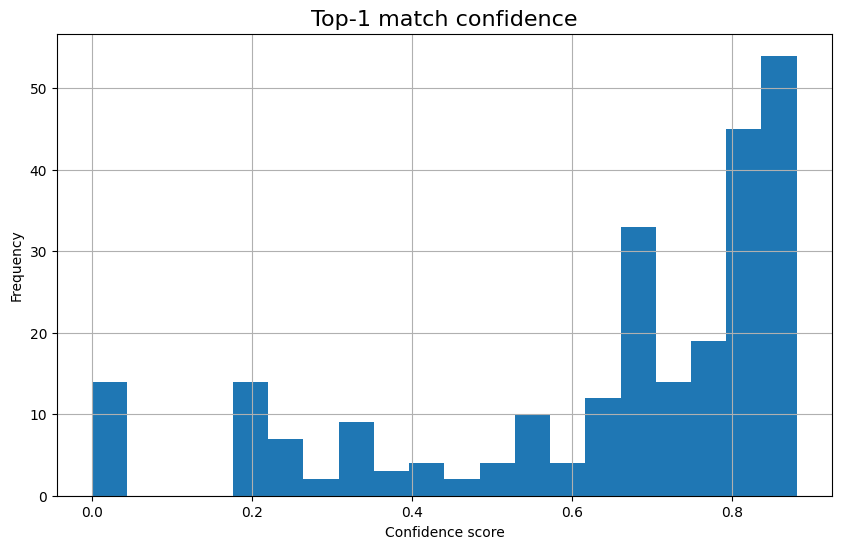

In [28]:
plt.figure(figsize=(10,6))
plt.hist(descriptions["top1_conf"], bins=20)
plt.title("Top-1 match confidence", fontsize=16)
plt.xlabel("Confidence score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


/tmp/ipython-input-2083604778.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


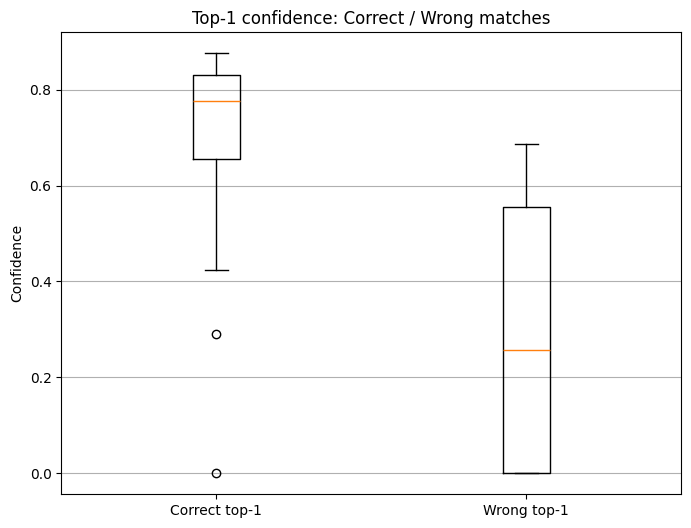

In [29]:
val_clean["top1_correct"] = (val_clean["top1_sku"] == val_clean["true_sku"])

plt.figure(figsize=(8,6))
data_correct = val_clean[val_clean["top1_correct"] == True]["top1_conf"]
data_wrong   = val_clean[val_clean["top1_correct"] == False]["top1_conf"]

plt.boxplot(
    [data_correct, data_wrong],
    labels=["Correct top-1", "Wrong top-1"]
)
plt.title("Top-1 confidence: Correct / Wrong matches")
plt.ylabel("Confidence")
plt.grid(True, axis='y')
plt.show()


Attribute extraction accuracy:
Color    80.0%
Brand    73.3%
Size     93.3%
dtype: object


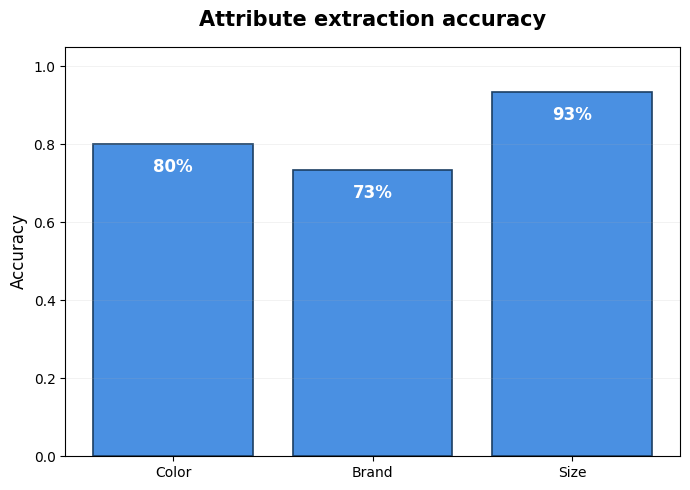

In [30]:
# attribute extraction accuracy

val_attr = val_clean.merge(
    catalog[["SKU", "Color", "Brand", "Size"]],
    left_on="true_sku",
    right_on="SKU",
    how="left"
)

val_attr["true_color"] = val_attr["Color"].astype(str).str.lower()
val_attr["true_brand"] = val_attr["Brand"].astype(str).str.lower()
val_attr["true_size"]  = val_attr["Size"].astype(str).str.lower()

val_attr["pred_color"] = val_attr["color_extracted"].astype(str).str.lower()
val_attr["pred_brand"] = val_attr["brand_extracted"].astype(str).str.lower()
val_attr["pred_size"]  = val_attr["size_extracted"].astype(str).str.lower()

# accuracy for each attribute
color_accuracy = (val_attr["pred_color"] == val_attr["true_color"]).mean()
brand_accuracy = (val_attr["pred_brand"] == val_attr["true_brand"]).mean()
size_accuracy  = (val_attr["pred_size"]  == val_attr["true_size"]).mean()

rates = pd.Series({
    "Color": color_accuracy,
    "Brand": brand_accuracy,
    "Size": size_accuracy
})

print("Attribute extraction accuracy:")
print(rates.apply(lambda x: f"{x:.1%}"))

# Plot
plt.figure(figsize=(7,5))

bars = plt.bar(
    ["Color", "Brand", "Size"],
    rates.values,
    color="#4a90e2",
    edgecolor="#1c3f63",
    linewidth=1.2
)

plt.ylim(0, 1.05)
plt.title("Attribute extraction accuracy", fontsize=15, fontweight="bold", pad=15)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(axis="y", alpha=0.18, linewidth=0.6)

for bar, v in zip(bars, rates.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        v - 0.08 if v > 0.1 else v + 0.02,
        f"{v:.0%}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
        color="white"
    )

plt.tight_layout()
plt.show()

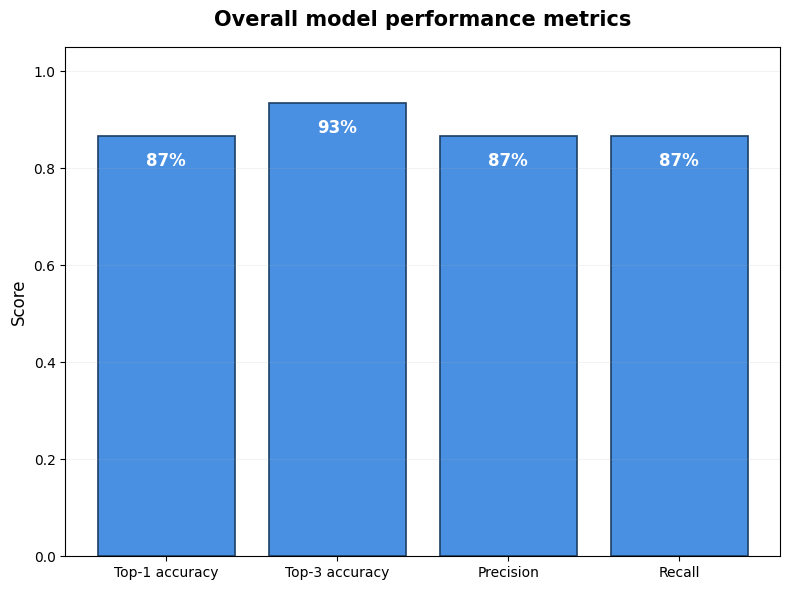

In [31]:
# metrics into a dict
metrics = {
    "Top-1 accuracy": top1_accuracy,
    "Top-3 accuracy": top3_accuracy,
    "Precision": precision,
    "Recall": recall
}

names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(8, 6))

bars = plt.bar(
    names,
    values,
    color="#4a90e2",
    edgecolor="#1c3f63",
    linewidth=1.2
)

plt.ylim(0, 1.05)
plt.title("Overall model performance metrics", fontsize=15, fontweight="bold", pad=15)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=0, ha="center")

plt.grid(axis="y", alpha=0.18, linewidth=0.6)

for bar, v in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        v - 0.07 if v > 0.1 else v + 0.02,
        f"{v:.0%}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
        color="white"
    )

plt.tight_layout()
plt.show()


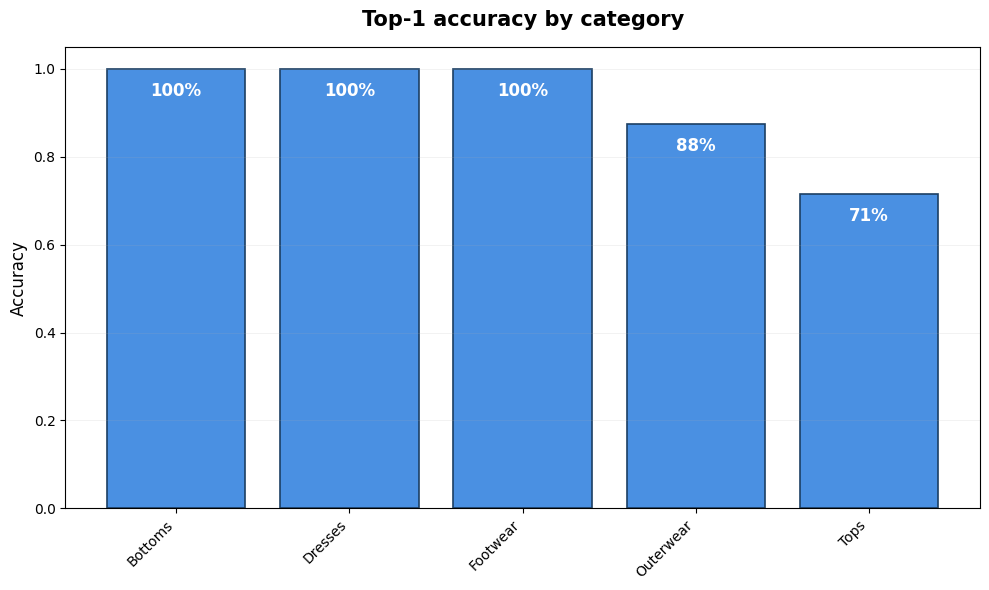

In [32]:
# bar chart of top-1 accuracy per category

# validation results with catalog ( to get the category of each true SKU)
val_cat = val_clean.merge(
    catalog[["SKU", "Category"]],
    left_on="true_sku",
    right_on="SKU",
    how="left"
)

# accuracy per category
acc_by_cat = (
    val_cat
    .groupby("Category")["top1_correct"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))

bars = plt.bar(
    acc_by_cat.index,
    acc_by_cat.values,
    color="#4a90e2",
    edgecolor="#1c3f63",
    linewidth=1.2
)

plt.ylim(0, 1.05)
plt.title("Top-1 accuracy by category", fontsize=15, fontweight="bold", pad=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45, ha="right")

plt.grid(axis="y", alpha=0.18, linewidth=0.6)

for bar, v in zip(bars, acc_by_cat.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        v - 0.07,
        f"{v:.0%}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
        color="white"
    )

plt.tight_layout()
plt.show()


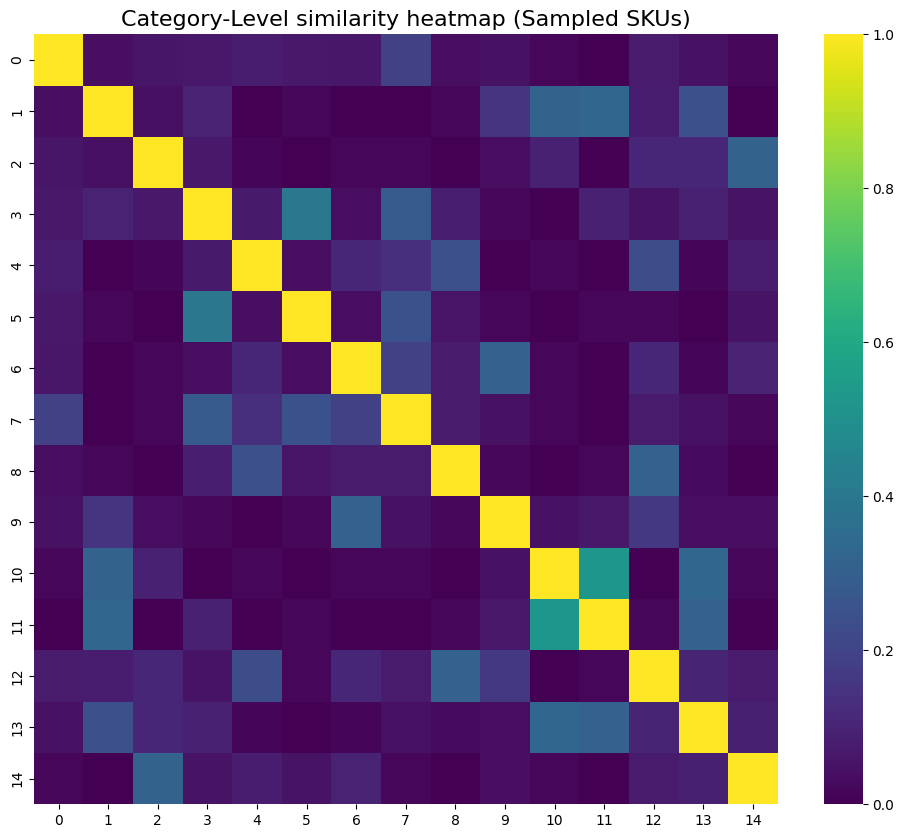

In [33]:
# sample
sample_catalog = catalog.groupby("Category").head(3).reset_index(drop=True)

#  tf-idf for sample
sample_vec = vectorizer.transform(sample_catalog["catalog_text"])

#similarity matrix
sim_matrix = cosine_similarity(sample_vec)

plt.figure(figsize=(12,10))
sns.heatmap(sim_matrix, annot=False, cmap="viridis")
plt.title("Category-Level similarity heatmap (Sampled SKUs)", fontsize=16)
plt.show()

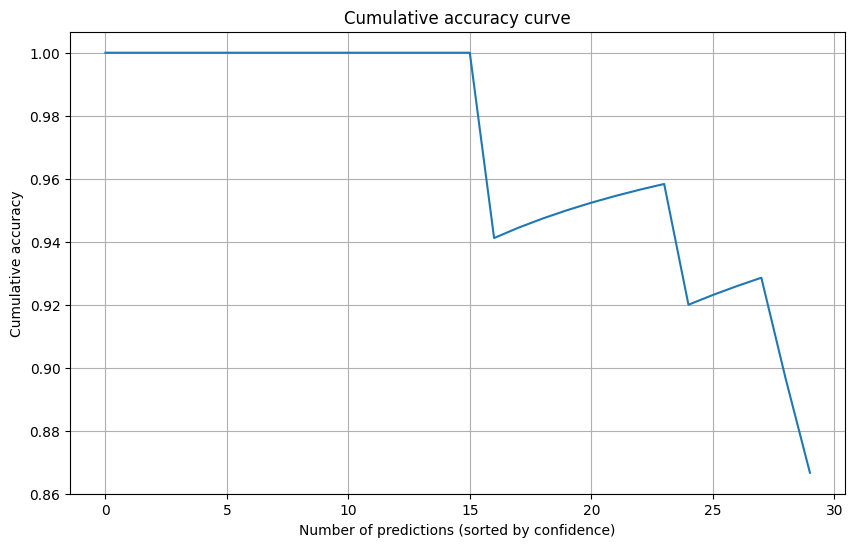

In [34]:
df = val_clean.copy()
df = df.sort_values("top1_conf", ascending=False).reset_index(drop=True)

df["correct_cumulative"] = df["top1_correct"].cumsum()
df["cumulative_accuracy"] = df["correct_cumulative"] / (df.index + 1)

plt.figure(figsize=(10,6))
plt.plot(df["cumulative_accuracy"])
plt.xlabel("Number of predictions (sorted by confidence)")
plt.ylabel("Cumulative accuracy")
plt.title("Cumulative accuracy curve")
plt.grid(True)
plt.show()

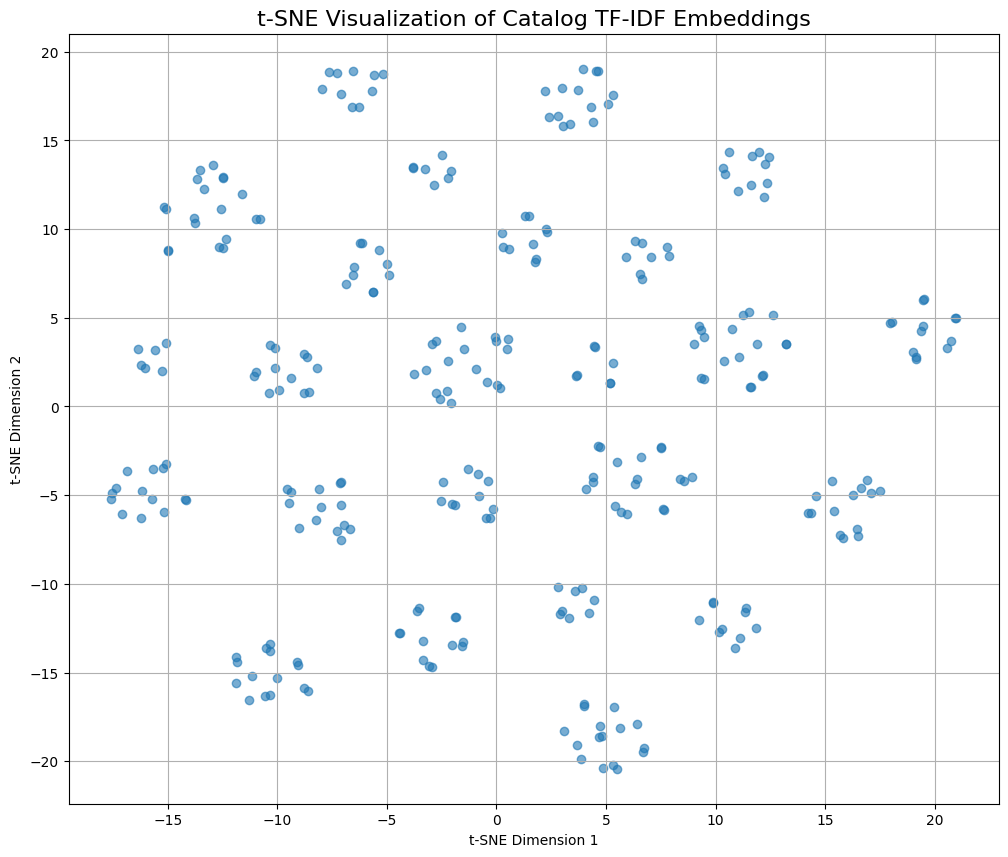

In [35]:
from sklearn.manifold import TSNE

sample = catalog.sample(300, random_state=42)
sample_vecs = vectorizer.transform(sample["catalog_text"])

# t-SNE projection to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(sample_vecs.toarray())

sample["x"] = tsne_result[:,0]
sample["y"] = tsne_result[:,1]

plt.figure(figsize=(12,10))
plt.scatter(sample["x"], sample["y"], alpha=0.6)

plt.title("t-SNE Visualization of Catalog TF-IDF Embeddings", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

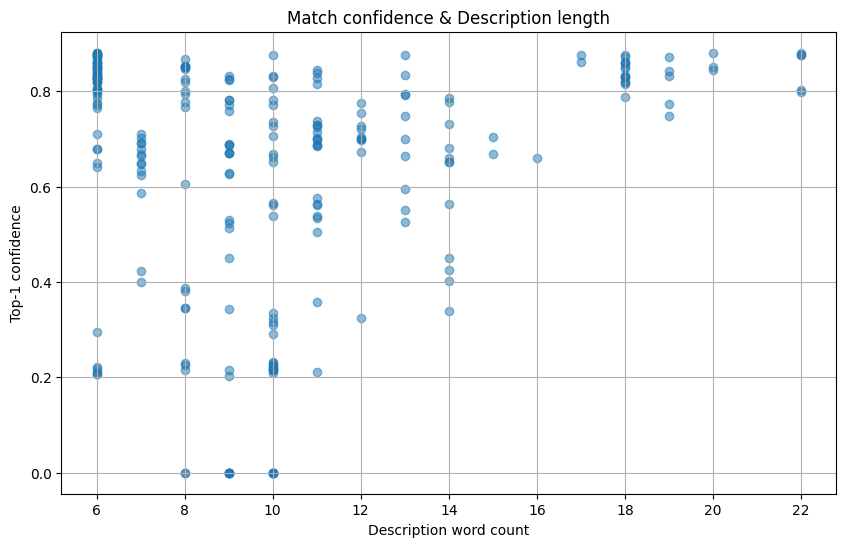

In [36]:
descriptions["desc_length"] = descriptions["clean_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
plt.scatter(descriptions["desc_length"], descriptions["top1_conf"], alpha=0.5)
plt.title("Match confidence & Description length")
plt.xlabel("Description word count")
plt.ylabel("Top-1 confidence")
plt.grid(True)
plt.show()


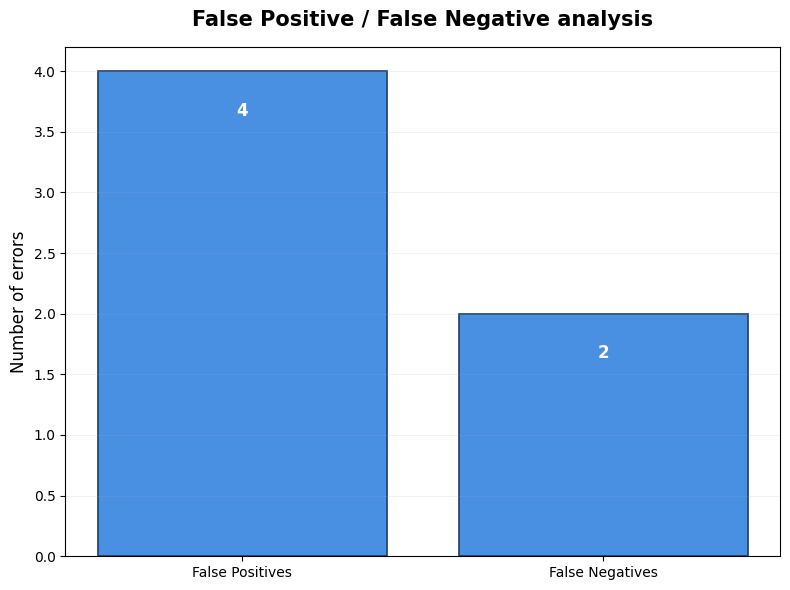

In [37]:
# counts
fp_count = (val_clean["top1_correct"] == False).sum()
fn_count = (val_clean["top3_correct"] == False).sum()

labels = ["False Positives", "False Negatives"]
values = [fp_count, fn_count]

plt.figure(figsize=(8,6))

bars = plt.bar(
    labels,
    values,
    color="#4a90e2",
    edgecolor="#1c3f63",
    linewidth=1.2
)

plt.title("False Positive / False Negative analysis", fontsize=15, fontweight="bold", pad=15)
plt.ylabel("Number of errors", fontsize=12)
plt.grid(axis="y", alpha=0.18, linewidth=0.6)

# labels
for bar, v in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        v - 0.4 if v > 1 else v + 0.2,
        str(v),
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
        color="white"
    )

plt.tight_layout()
plt.show()


## 10. Extended attribute extraction (color, brand, size, material)

In [38]:
# for material

materials_catalog = set(
    catalog["Material"]
    .dropna()
    .astype(str)
    .str.lower()
    .unique()
)


In [39]:
def extract_material(text: str):
    t = str(text).lower()
    tokens = tokenize(t)

    # exact match
    for tok in tokens:
        if tok in materials_catalog:
            return tok

    #fuzzy match
    best_mat, best_score = None, 0
    for tok in tokens:
        if len(tok) <= 2:
            continue

        match = process.extractOne(
            tok,
            list(materials_catalog),
            scorer=fuzz.WRatio
        )
        if match and match[1] > best_score:
            best_mat, best_score = match[0], match[1]

    if best_mat and best_score >= 80:
        return best_mat

    return None


In [40]:
def extract_attributes(text: str):
    return {
        "color": extract_color(text),
        "brand": extract_brand(text),
        "size": extract_size(text),
        "material": extract_material(text),
    }

extract_attributes("Looking for a navy fleece cardigan size M from style")

{'color': 'navy', 'brand': 'style', 'size': 'm', 'material': 'fleece'}

In [41]:
test = "Looking for a navy cardigan size M"

clean = clean_text(test)

row = pd.Series({
    "Unstructured_Description": test,
    "clean_text": clean,
    "color_extracted": extract_color(test),
    "brand_extracted": extract_brand(test),
    "size_extracted": extract_size(test)
})

match_description(row, top_k=3)

[{'rank': 1, 'SKU': 'SKU1000020', 'confidence': 0.6912224588015743},
 {'rank': 2, 'SKU': 'SKU1000507', 'confidence': 0.1907486305188646},
 {'rank': 3, 'SKU': 'SKU1000753', 'confidence': 0.18728790724809496}]